# Loading the data

In [1]:
from collections import defaultdict
import glob
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.naive_bayes import MultinomialNB
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cik2year_category = defaultdict(list)
category2year_cik = defaultdict(list)
all_categories = list(pd.read_excel('descriptive_words.xls')['SIC3'])
with open('labeled_firms_single.txt', 'r') as f:
    lines = f.read().split('\n')[1:]
for l in [l for l in lines if l]:
    _, str_cik ,_, str_year, str_category = l.split('\t')
    category = int(str_category[2:-2])
    assert(category in all_categories)
    if category % 10 != 0:
        super_category = int(category/10)*10
    else:
        super_category = None # Category ends with '0', it already is a supercategory
    year = int(str_year)
    cik = int(str_cik)
    cik2year_category[cik].append([year, category])
    category2year_cik[category].append([year, cik])
    if super_category:
        cik2year_category[cik].append([year, super_category])
        category2year_cik[super_category].append([year, cik])

In [4]:
len(cik2year_category)

2930

In [22]:
desc_table = pd.read_excel('descriptive_words.xls')
d_words = {}
for cat in all_categories:
    row = desc_table[desc_table['SIC3'] == cat]
    d_words[cat] = row[row.columns[2:]].dropna(axis=1).loc[row.index[0]].tolist()

# Assessing the quality of the baseline strategies

In [96]:
def best(cik, all_cat=all_categories):
    '''This oracle returns the perfect answer.'''
    return [x[1] for x in cik2year_category[cik] if x[1] in all_cat]

def worst(cik, all_cat=all_categories):
    '''This anti_oracle returns the worst possible answer : all the categories the company does not belong to.'''
    perfect_answer = best(cik)
    return [x for x in all_cat if not x in perfect_answer]

def coin_toss(cik, all_cat=all_categories):
    '''For each category, returns it if a coin lands on heads'''
    return [x for x in all_cat if np.random.rand() >= .5]
best(1057187)

[874, 870]

In [90]:
def score(f, cik, all_cat=all_categories):
    '''Return the number of false positives and false negatives produced by f on company cik'''
    actual = set(best(cik, all_cat=all_cat))
    predicted = set(f(cik, all_cat=all_cat))
    FP = len(predicted - actual)
    FN = len(actual - predicted)
    return FP, FN
score(best, 1057187), score(worst, 1057187), score(coin_toss, 1057187)

((0, 0), (501, 2), (269, 1))

In [134]:
def score_all(f, all_cat=all_categories, nb=None):
    '''Return the list of [FP, FN] couples on all cik for which we know the answer'''
    answer = []
    ciks = [random.choice(list(cik2year_category.keys())) for _ in range(0,nb)] if nb else cik2year_category.keys()
    for cik in ciks:
        try:
            answer.append(score(f, cik, all_cat=all_cat))
        except FileNotFoundError:
            pass  # If the text file of the company is not there, we simply don't include the results
    return answer
score_all(best)[:10], score_all(worst)[:10], score_all(coin_toss)[:10]

([(0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0)],
 [(501, 2),
  (501, 2),
  (502, 1),
  (501, 2),
  (501, 2),
  (501, 2),
  (501, 2),
  (501, 2),
  (501, 2),
  (501, 2)],
 [(253, 0),
  (253, 2),
  (257, 1),
  (267, 0),
  (229, 1),
  (249, 1),
  (241, 2),
  (248, 1),
  (260, 2),
  (252, 1)])

(None, None, None)

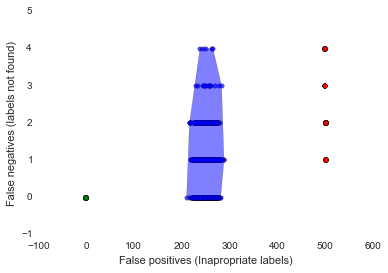

In [135]:
def plot(f, color, all_cat=all_categories, nb=None):
    '''Plot the results for f'''
    XY = np.array(score_all(f, all_cat=all_cat, nb=nb))
    X = XY[:,0]
    Y = XY[:,1]
    try:
        hull = ConvexHull(XY)
        hullXY = hull.points[hull.vertices]
        plt.fill(hullXY[:,0], hullXY[:,1], color, alpha=.5)
    except:  # Meaning to catch QhullError when all points are in the same spot
        pass
    plt.scatter(X,Y, c=color, alpha=.7)
    plt.xlabel('False positives (Inapropriate labels)')
    plt.ylabel('False negatives (labels not found)')
plot(best, 'g'), plot(worst, 'r'), plot(coin_toss, 'b')

# Assessing the quality of the classifiers trained in Exp2

(None, None, None)

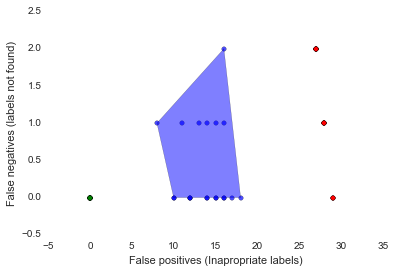

In [196]:
clf_table = pd.read_csv('Exp2/classif_results.csv')
all_classifiable_categories = clf_table['C'].tolist()
restricted_plot = lambda f,c:plot(f, c, all_cat=all_classifiable_categories, nb=20)
restricted_plot(best, 'g'), restricted_plot(worst, 'r'), restricted_plot(coin_toss, 'b')

In [197]:
classifiers = {}
count_vectorizers = {}
tfidf_transformers = {}
for c in all_classifiable_categories:
    count_vectorizers[c] = pickle.load(open('Exp2/'+str(c)+'_count_vect.pickle', 'rb'))
    tfidf_transformers[c] = pickle.load(open('Exp2/'+str(c)+'_tfidf_transformer.pickle', 'rb'))
    classifiers[c] = pickle.load(open('Exp2/'+str(c)+'_classifier.pickle', 'rb'))

assert(classifiers.keys() == tfidf_transformers.keys())

def cik2text(cik):
    files = glob.glob('1998/{}-*'.format(cik))
    if not files or len(files) > 1:
        files = glob.glob('1999/{}-*'.format(cik))
    if not files or len(files) > 1:
        raise FileNotFoundError
    with open(files[0], 'r') as f:
        return f.read()

In [198]:
def clf_predict(cik, all_cat=all_classifiable_categories):
    text = cik2text(cik)
    answer=[]
    for cat in all_cat:
        count = count_vectorizers[cat]
        tfidf = tfidf_transformers[cat]
        clf = classifiers[cat]
        X = tfidf.transform(count.transform(text))
        if clf.predict(tfidf.transform(count.transform([text]))) == 1:
            answer.append(cat)
    return answer

(None, None, None, None)

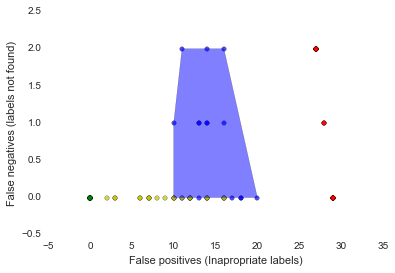

In [199]:
restricted_plot(best, 'g'), restricted_plot(worst, 'r'), restricted_plot(coin_toss, 'b'), restricted_plot(clf_predict, 'y')

# Deterministic tactics to predict category from descriptive words

## Any match

In [146]:
desc_regexps = {cat: re.compile('('+'|'.join(d_words[cat])+')') for cat in all_categories}

(None, None, None, None)

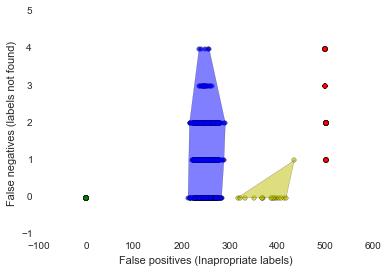

In [151]:
def any_match(cik, all_cat=all_categories):
    '''Return all categories for which any descriptive word is in the text'''
    text = cik2text(cik)
    answer = []
    for cat in all_cat:
        if desc_regexps[cat].search(text):
            answer.append(cat)
    return answer
plot(best, 'g'), plot(worst, 'r'), plot(coin_toss, 'b'), plot(any_match, 'y', nb=20)

## All must match

(None, None, None, None)

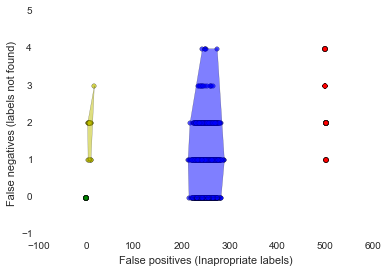

In [155]:
def all_must_match(cik, all_cat=all_categories):
    '''Return all categories for which all descriptive words are in the text'''
    text = cik2text(cik)
    answer = []
    for cat in all_cat:
        add = True
        for word in d_words[cat]:
            if not word in text:
                add = False
                break
        if add:
            answer.append(cat)
    return answer
plot(best, 'g'), plot(worst, 'r'), plot(coin_toss, 'b'), plot(all_must_match, 'y', nb=20)

## N most matching

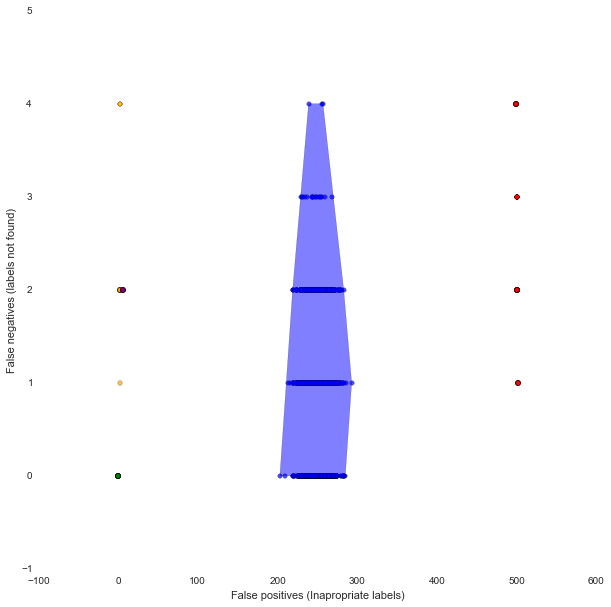

In [167]:
def n_most_matching(cik, n, all_cat=all_categories):
    '''Return the n categories with the highest percentage of matching words'''
    text = cik2text(cik)
    matching_prop = {}  # \in [0;1], the proportion of descriptive words in the text
    for cat in all_cat:
        matching_prop[cat] = 0
        for word in d_words[cat]:
            if word in text:
                matching_prop[cat] += 1
        matching_prop[cat] /= len(d_words[cat])
    sorted_cats = sorted(list(matching_prop.keys()), key=lambda k: matching_prop[k])
    return sorted_cats[0:n+1]

def most_matching(cik, all_cat=all_categories):
    return n_most_matching(cik, 1, all_cat=all_cat)

def most_2_matching(cik, all_cat=all_categories):
    return n_most_matching(cik, 2, all_cat=all_cat)

def most_5_matching(cik, all_cat=all_categories):
    return n_most_matching(cik, 5, all_cat=all_cat)

def most_20_matching(cik, all_cat=all_categories):
    return n_most_matching(cik, 5, all_cat=all_cat)

plt.figure(figsize=(10,10))
plot(best, 'g'), plot(worst, 'r'), plot(coin_toss, 'b'), plot(most_matching, 'y', nb=20)
plot(most_2_matching, 'orange', nb=20), plot(most_5_matching, 'pink', nb=20)
plot(most_20_matching, 'purple', nb=20)
#plt.close()

## Any match within rank k

ERROR! Session/line number was not unique in database. History logging moved to new session 28


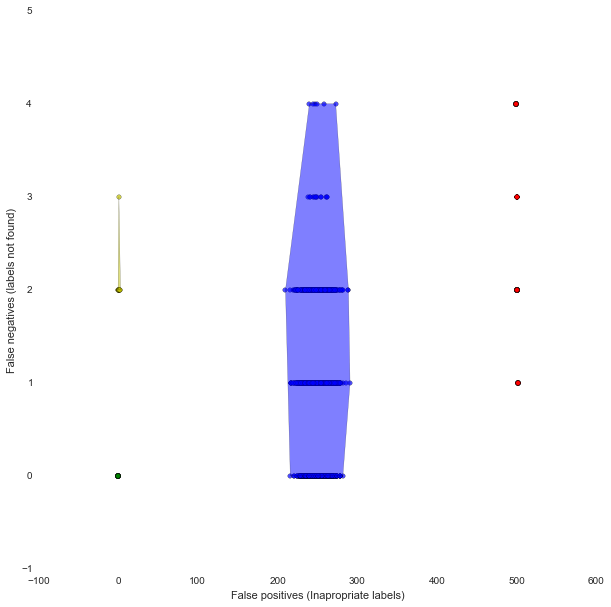

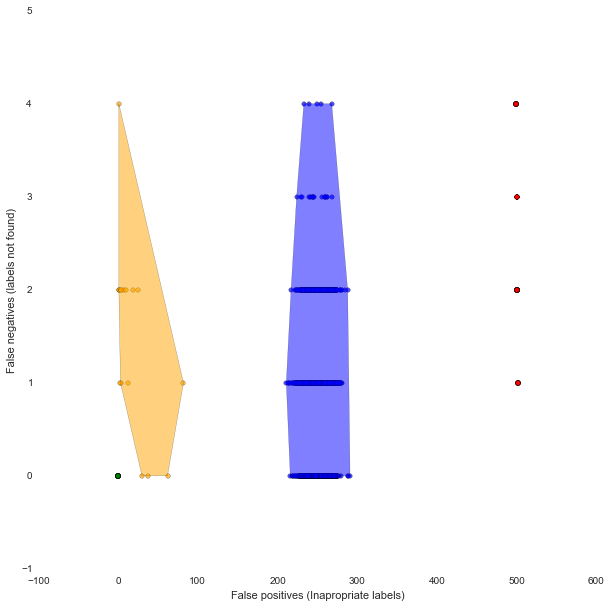

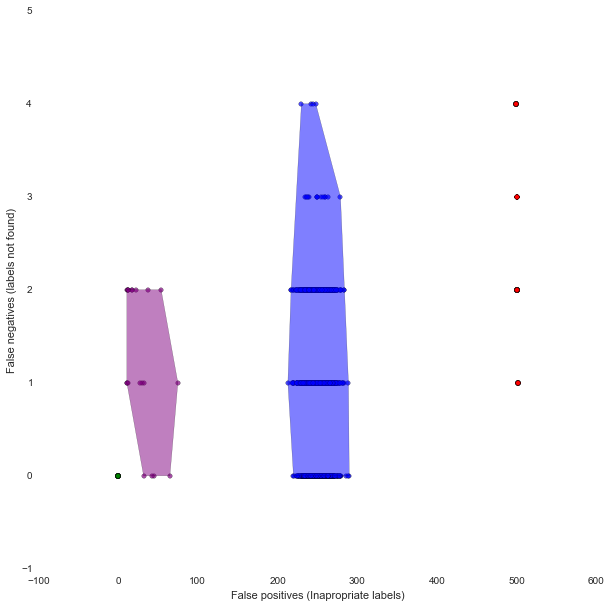

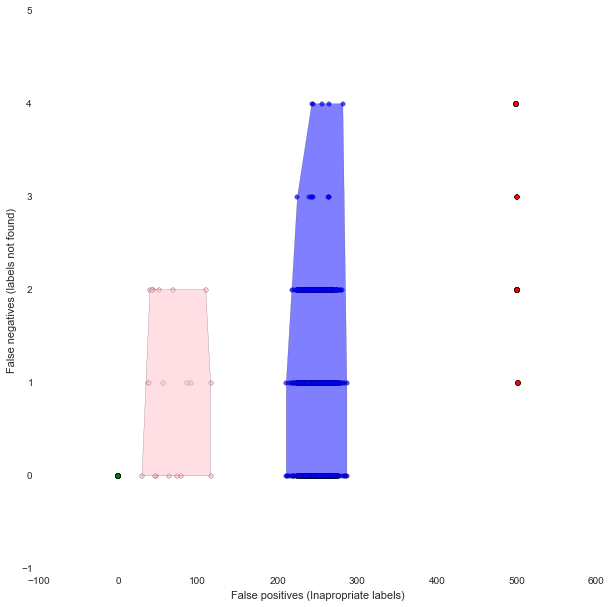

In [195]:
def match_within_rank_k(cik, k, all_cat=all_categories):
    '''Return the categories for which any descriptive word has rank <= k in the company's description'''
    text = cik2text(cik)
    count_vect = CountVectorizer(stop_words='english')
    X = list(count_vect.fit_transform([text]).toarray().reshape(-1))
    voc = {v: k for k, v in count_vect.vocabulary_.items()}
    words_of_rank_k = []
    for _ in range(0,k):
        index = np.argmax(X)
        words_of_rank_k.append(voc[index])
        X.pop(index)
    words_of_rank_k = set(words_of_rank_k)
    answer = []
    for cat in all_cat:
        if len(words_of_rank_k & set(d_words[cat])) > 0:
            answer.append(cat)
    return answer

def match_within_rank_1(cik, all_cat=all_categories):
    return match_within_rank_k(cik, 1, all_cat=all_cat)

def match_within_rank_10(cik, all_cat=all_categories):
    return match_within_rank_k(cik, 10, all_cat=all_cat)

def match_within_rank_30(cik, all_cat=all_categories):
    return match_within_rank_k(cik, 30, all_cat=all_cat)

def match_within_rank_100(cik, all_cat=all_categories):
    return match_within_rank_k(cik, 100, all_cat=all_cat)

plt.figure(figsize=(10,10))
plot(best, 'g'), plot(worst, 'r'), plot(coin_toss, 'b'), plot(match_within_rank_1, 'y', nb=20)
plt.figure(figsize=(10,10))
plot(best, 'g'), plot(worst, 'r'), plot(coin_toss, 'b')
plot(match_within_rank_10, 'orange', nb=20)
plt.figure(figsize=(10,10))
plot(best, 'g'), plot(worst, 'r'), plot(coin_toss, 'b')
plot(match_within_rank_30, 'purple', nb=20)
plt.figure(figsize=(10,10))
plot(best, 'g'), plot(worst, 'r'), plot(coin_toss, 'b')
plot(match_within_rank_100, 'pink', nb=20)